DEMARRAGE DU SCRIPT GLOBAL TP1

PARTIE 1 : ANALYSE RISQUE PORTEFEUILLE

Résultats Analyse Portefeuilles :
             Nom  Moyenne  Volatilité  Rendement Annuel  VaR 95% (€)  Sharpe
A (Conservateur)     0.94        1.65             11.85     45649.38    5.35
    B (Agressif)     2.89       15.41             40.79     77230.68    2.45


/tmp/ipython-input-2187896320.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([rendements_A, rendements_B], labels=['A', 'B'])


✓ Graphique sauvegardé : graphique_partie1.png

PARTIE 2 : SCORING CREDIT BAYESIEN
Prior Initial : 5.0%
Après Retard  : 29.63% (Facteur x5.9)
Après Découvert : 64.60% (Facteur Cumulé x12.9)
Precision Matrice Confusion : 29.63%
✓ Cohérence Bayes/Precision vérifiée.

PARTIE 3 : MACHINE LEARNING (KNN)
Recherche K optimal...
Meilleur K trouvé : 25

Résultats Modèle (Seuil 0.08):
Matrice : TP=90, FP=407, FN=10, TN=93
Recall : 90.0%
ROI Net : 508,100 €
✓ Graphique sauvegardé : graphique_roc_knn.png


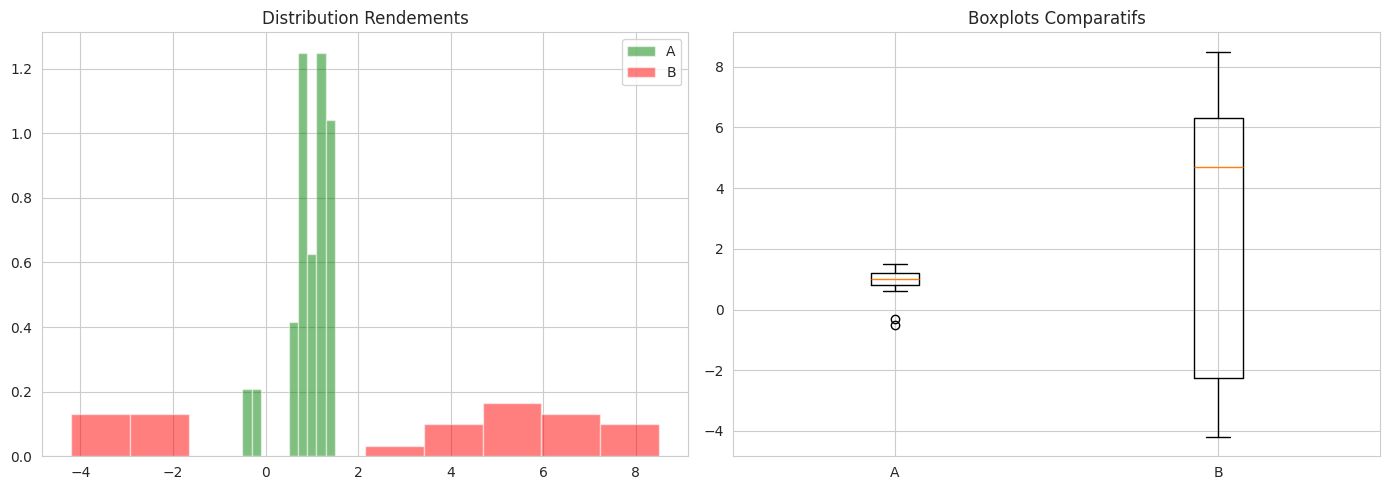

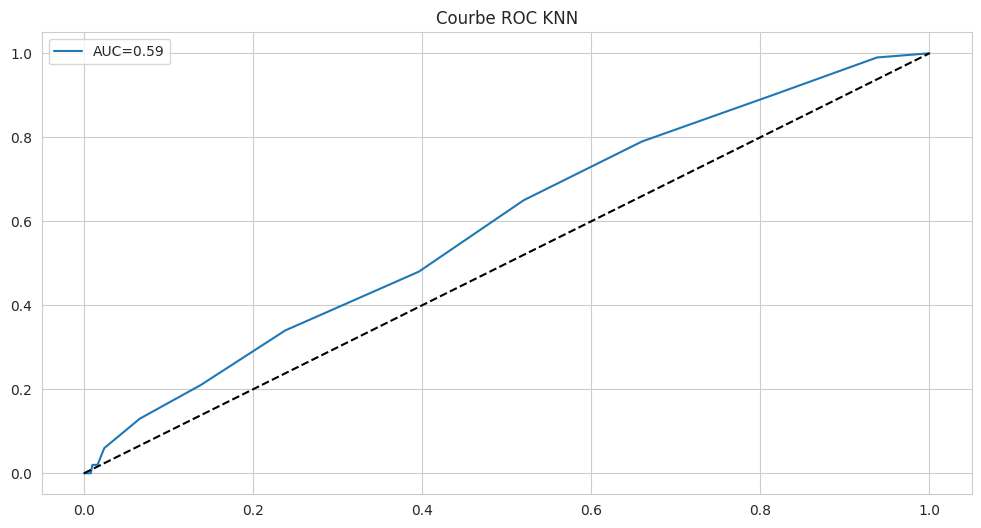

In [1]:

# ==============================================================================
# TP1 : INTELLIGENCE ARTIFICIELLE EN FINANCE
# Code Source Complet - Parties 1, 2 et 3
# Auteur : HOUTATE SAID / JAMAL YASSINE
# Date : 17 Février 2026
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_score, recall_score, f1_score)

# Configuration globale
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)  # Reproductibilité

print("="*80)
print("DEMARRAGE DU SCRIPT GLOBAL TP1")
print("="*80)

# ==============================================================================
# PARTIE 1 : STATISTIQUES ET LOI NORMALE EN FINANCE
# ==============================================================================
print("\n" + "="*80)
print("PARTIE 1 : ANALYSE RISQUE PORTEFEUILLE")
print("="*80)

# 1. Données
rendements_A = np.array([1.2, 0.8, -0.5, 1.5, 0.9, 1.1, 0.7, 1.3, 1.0, 0.6, 1.4, 0.8,
                         1.1, 0.9, -0.3, 1.2, 1.0, 1.5, 0.8, 1.3, 0.9, 1.1, 1.2, 1.0])
rendements_B = np.array([4.5, -2.1, 6.2, -3.5, 5.8, 7.1, -1.8, 4.9, 3.2, -4.2, 8.5, -2.7,
                         5.1, 6.8, -3.1, 7.3, 4.5, -2.9, 6.7, 5.3, -3.8, 7.9, 4.2, 5.5])
capital = 500000
rf = 3.0 # Taux sans risque

# 2. Fonctions Calculs
def analyser_portefeuille(rendements, nom):
    mu = np.mean(rendements)
    sigma = np.std(rendements, ddof=1)
    ann_ret = ((1 + mu/100)**12 - 1) * 100
    ann_vol = sigma * np.sqrt(12)

    # VaR 95% Paramétrique
    z = stats.norm.ppf(0.05) # -1.645
    var_ann_pct = ann_ret + z * ann_vol
    var_euro = capital * (var_ann_pct/100)

    # Sharpe
    sharpe = (ann_ret - rf) / ann_vol

    return {
        "Nom": nom, "Moyenne": mu, "Volatilité": ann_vol,
        "Rendement Annuel": ann_ret, "VaR 95% (€)": var_euro,
        "Sharpe": sharpe
    }

res_A = analyser_portefeuille(rendements_A, "A (Conservateur)")
res_B = analyser_portefeuille(rendements_B, "B (Agressif)")

# 3. Affichage Résultats P1
df_p1 = pd.DataFrame([res_A, res_B])
print("\nRésultats Analyse Portefeuilles :")
print(df_p1.round(2).to_string(index=False))

# 4. Visualisation (Sauvegarde)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].hist(rendements_A, alpha=0.5, label='A', color='green', density=True)
ax[0].hist(rendements_B, alpha=0.5, label='B', color='red', density=True)
ax[0].legend(); ax[0].set_title("Distribution Rendements")
ax[1].boxplot([rendements_A, rendements_B], labels=['A', 'B'])
ax[1].set_title("Boxplots Comparatifs")
plt.tight_layout()
plt.savefig("graphique_partie1.png")
print("✓ Graphique sauvegardé : graphique_partie1.png")


# ==============================================================================
# PARTIE 2 : THÉORÈME DE BAYES
# ==============================================================================
print("\n" + "="*80)
print("PARTIE 2 : SCORING CREDIT BAYESIEN")
print("="*80)

def bayes_update(prior, p_e_h, p_e_not_h):
    p_evidence = p_e_h * prior + p_e_not_h * (1 - prior)
    return (p_e_h * prior) / p_evidence

# Scénario Q2.1 & Q2.2
prior_init = 0.05
# Evt 1: Retard (80% / 10%)
post_1 = bayes_update(prior_init, 0.80, 0.10)
# Evt 2: Découvert (65% / 15%)
post_2 = bayes_update(post_1, 0.65, 0.15)

print(f"Prior Initial : {prior_init:.1%}")
print(f"Après Retard  : {post_1:.2%} (Facteur x{post_1/prior_init:.1f})")
print(f"Après Découvert : {post_2:.2%} (Facteur Cumulé x{post_2/prior_init:.1f})")

# Matrice Confusion Precision
tp, fp = 400, 950
precision = tp / (tp + fp)
print(f"Precision Matrice Confusion : {precision:.2%}")
print("✓ Cohérence Bayes/Precision vérifiée.")


# ==============================================================================
# PARTIE 3 : KNN & EVALUATION
# ==============================================================================
print("\n" + "="*80)
print("PARTIE 3 : MACHINE LEARNING (KNN)")
print("="*80)

# 1. Génération Data
n_samples = 2000
age = np.random.randint(25, 66, n_samples)
salaire = np.random.normal(50000, 20000, n_samples).clip(20000, 120000)
anciennete = np.random.exponential(5, n_samples).clip(0, 30)
dette = np.random.normal(25000, 15000, n_samples).clip(0, 80000)
ratio = dette / salaire
credits = np.random.poisson(1.5, n_samples).clip(0, 5)
retards = np.random.poisson(2, n_samples).clip(0, 10)
score = np.random.normal(650, 100, n_samples).clip(300, 850)

defaut_proba = (0.05 + 0.15*(ratio>0.5) + 0.10*(retards>3) +
                0.08*(score<600) + 0.05*(credits>2)).clip(0, 0.85)
defaut = (np.random.rand(n_samples) < defaut_proba).astype(int)

df = pd.DataFrame({'ratio': ratio, 'retards': retards, 'score': score,
                   'dette': dette, 'salaire': salaire, 'anciennete': anciennete,
                   'credits': credits, 'age': age, 'defaut': defaut})

# 2. Preprocessing
X = df.drop('defaut', axis=1)
y = df['defaut']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 3. Optimisation K
print("Recherche K optimal...")
res_k = []
for k in [5, 15, 25, 30]:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_s, y_train, cv=3, scoring='roc_auc').mean()
    res_k.append((k, score))
best_k = max(res_k, key=lambda x: x[1])[0]
print(f"Meilleur K trouvé : {best_k}")

# 4. Modèle Final & ROI
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_s, y_train)
probs = knn_final.predict_proba(X_test_s)[:, 1]

# Seuil optimisé ROI (0.08)
thr = 0.08
preds = (probs >= thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

roi = (tp * 15000) - (fp * 1700) - (fn * 15000)
recall = recall_score(y_test, preds)

print(f"\nRésultats Modèle (Seuil {thr}):")
print(f"Matrice : TP={tp}, FP={fp}, FN={fn}, TN={tn}")
print(f"Recall : {recall:.1%}")
print(f"ROI Net : {roi:,.0f} €")

# Courbe ROC (Sauvegarde)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, probs):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("Courbe ROC KNN")
plt.legend()
plt.savefig("graphique_roc_knn.png")
print("✓ Graphique sauvegardé : graphique_roc_knn.png")